In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Inspecting the columns of station table
inspector = inspect(engine)
station_columns = inspector.get_columns('Station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Inspecting the columns of measurement table
measurement_columns = inspector.get_columns('Measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f"The most recent date is : {recent_date[0]}")

The most recent date is : 2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Convert date from string
final_date = dt.datetime.strptime(recent_date[0],"%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
one_year_prior = final_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= one_year_prior).all()
precipitation_data

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
data = data.set_index('Date')
# data = data.rename
# Sort the dataframe by date
data = data.sort_values('Date')
data.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


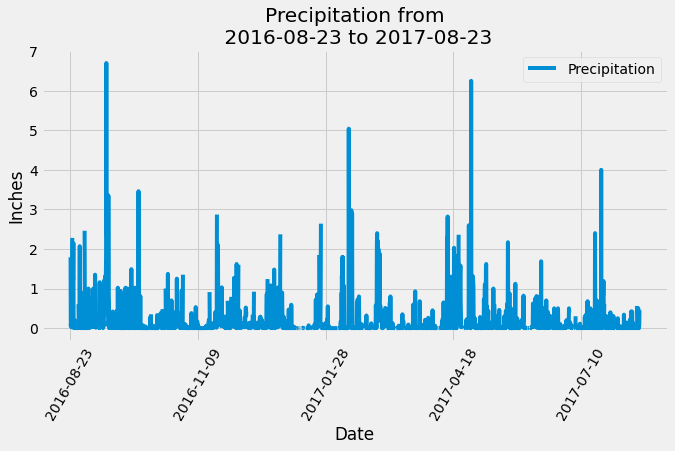

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
data.plot(rot=60, figsize=(10,5))
plt.title(f'Precipitation from\n {one_year_prior} to {final_date}')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.savefig(('graph_images/precipitation.png'), bbox_inches='tight')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Station.station).count()
print(f"There are {stations_count} total stations in the data ")

There are 9 total stations in the data 


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_freq = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Station with highest number of observations
max_obv = station_freq[0]
print(f'The station with the highest number of observations is: {max_obv[0]}')

The station with the highest number of observations is: USC00519281


In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Summary Temperatures for station
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == max_obv[0]).all()

# Print results for summary temps
print(f'The lowest temperature recorded for station {max_obv[0]} was: {summary_temps[0][0]}')
print(f'The highest temperature recorded for station {max_obv[0]} was: {summary_temps[0][1]}')
print(f'The average temperature recorded for station {max_obv[0]} was: {summary_temps[0][2]}')

The lowest temperature recorded for station USC00519281 was: 54.0
The highest temperature recorded for station USC00519281 was: 85.0
The average temperature recorded for station USC00519281 was: 71.66378066378067


In [69]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_final_date = session.query(Measurement.date).filter(Measurement.station == max_obv[0]).order_by(Measurement.date.desc()).first()

# Convert date from string
station_final_date = dt.datetime.strptime(station_final_date[0],"%Y-%m-%d").date()

# Calculate the date one year from the last date of filtered data
station_oneyear = station_final_date - dt.timedelta(days=365)

# Create query for highest observation station temps over 12 months
station_data = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == max_obv[0]).\
                filter(Measurement.date >= station_oneyear).\
                order_by(Measurement.date.asc()).all()

# Create dataframe for station temps over last 12 months
station_df = pd.DataFrame(station_data).set_index('date')

# Display dataframe head
station_df.head()

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


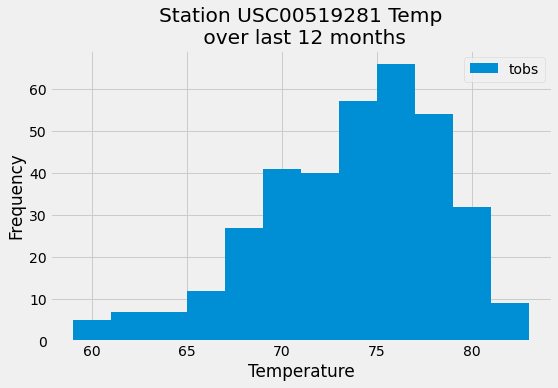

In [91]:
# Plot results as histogram
station_df.plot(kind='hist', bins=12, figsize=(8,5), title=(f'Station {max_obv[0]} Temp\n over last 12 months'))
plt.xlabel('Temperature')
plt.savefig(('graph_images/station_temps.png'), bbox_inches='tight')
plt.show()

# Close session

In [92]:
# Close Session
session.close()